# Diego Muñoz, Aaron Pozas — Tarea 2 (Ítem 1)

**Clustering** sobre `hour.csv` (Bike Sharing Dataset — registro horario)

**Archivo:** `Diego_Munoz_Tarea2.ipynb`

**Objetivo:** ejecutar K-Means (random), K-Means++ y MeanShift con al menos 4 configuraciones cada uno sobre el 80% del dataset (omitiendo `season` en el entrenamiento), evaluar con Silhouette y métricas complementarias (ARI, NMI), seleccionar las 3 mejores configuraciones, aplicarlas al 20% restante y comparar la etiqueta real `season` con la etiqueta dominante del cluster. Además, se incluyen experimentos de robustez y un breve análisis.

---



## Instrucciones y estructura del notebook (leer antes de ejecutar)

1. Este notebook está preparado para ejecutarse en Google Colab o Jupyter. Ejecuta celda a celda.
2. Se descarga `hour.csv` automáticamente desde UCI si hay conexión. Si trabajas sin internet, sube `hour.csv` al entorno y omite la descarga.
3. Este notebook realiza DOS experimentos: **(A) incluyendo features temporales** (`yr`, `mnth`, `hr`) y **(B) excluyéndolas** para evaluar el *leak* temporal.
4. Para cada experimento se ejecutan:
   - KMeans (init=random) con k=[4,6,8,10]
   - KMeans++ con k=[4,6,8,10]
   - MeanShift con 4 quantiles/bandwidths (estimación automática y grid search)
   - MiniBatchKMeans (k=4,8) para eficiencia
   - DBSCAN (parámetros ejemplares) para ver clusters no convexos
5. Métricas calculadas: **Silhouette**, **Adjusted Rand Index (ARI)**, **Normalized Mutual Information (NMI)**, **pureza por cluster**, **test accuracy usando label dominante**, matriz de confusión y PCA 2D para visualización.
6. Al final encontrarás: conclusiones, recomendaciones y un guion listo para tu video explicativo que cumple el ítem 1.

> **Nota:** el requisito de tamaño (>=10,000 filas) se cumple usando `hour.csv` (~17k filas).


### 1) Importar librerías

Importamos las librerías necesarias y configuramos estilo y opciones. Usa `seaborn` para gráficos, `sklearn` para clustering y métricas, y fijamos semillas globales para reproducibilidad

In [ ]:

# 1) Importar librerías y funciones auxiliares
import os, zipfile, json
from urllib.request import urlretrieve
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth, MiniBatchKMeans, DBSCAN
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score, accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from collections import Counter
pd.set_option('display.max_columns', 200)
sns.set_style('whitegrid')
print("Librerías cargadas.")


### 2) Descarga y carga `hour.csv`

Descarga automática desde UCI si el archivo no se encuentra presente. Si trabajas sin internet, sube `hour.csv` manualmente y salta esta celda. 

Imprime además una tabla resumen del dataset a utilizar.

In [ ]:
data_file = "hour.csv"

if not os.path.exists(data_file):

    print("Descargando Bike Sharing Dataset (hour.csv) desde UCI ...")

    zip_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip"
    zip_name = "bike_sharing.zip"

    urlretrieve(zip_url, zip_name)
    with zipfile.ZipFile(zip_name, 'r') as z:
        z.extract('hour.csv')
    os.remove(zip_name)

else:
    
    print("hour.csv ya existe, cargando localmente.")

df = pd.read_csv(data_file)
print("Shape total:", df.shape)
df.head()


### 3) Preprocesamiento y selección de features

Eliminamos columnas que "filtran" o duplican la etiqueta (por ejemplo `casual`, `registered`, `cnt`). Separamos `season` como `y` y dejamos sólo variables numéricas en `X_num`. Imprimimos números de filas para demostrar que hay >10k.

In [ ]:
# Eliminamos columnas irrelevantes (contadores que filtran la etiqueta)
drop_cols = [c for c in ['instant','dteday','casual','registered','cnt'] if c in df.columns]
df = df.drop(columns=drop_cols)

# Aseguramos la existencia de 'season' como etiqueta target
if 'season' not in df.columns:
    raise ValueError("No se encontró la columna 'season' en hour.csv")

y_full = df['season'].astype(int)
X_full = df.drop(columns=['season'])

# Seleccionamos caracteristicas numericas
X_num = X_full.select_dtypes(include=[np.number]).copy()
print("Features numéricas disponibles:", X_num.columns.tolist())

# Guardamos numero de filas para referencia
print("Número total de filas:", len(df))


### 4) Justificaciones rápidas de configuraciones

#### K-Means (Inicialización Random y K-Means++)

- $K = 4$: Se selecciona k=4 porque existen exactamente 4 estaciones en el dataset (primavera, verano, otoño, invierno). Nos permite evaluar si el algoritmo puede recuperar naturalmente estas categorías sin supervisión.

- $K = 6$: Buscamos permitir que se formen subgrupos dentro de cada estación. Por ejemplo, podrían emerger clusters que diferencien entre horas pico y horas valle, o entre días laborales y fines de semana dentro de una misma estación.

- $K = 8$: Esta configuración explora una sobredescomposición controlada. Con más clusters de los esperados, podemos detectar patrones más granulares como combinaciones de factores horarios y meteorológicos que podrían estar enmascarados con menos clusters.

- $K = 10$: Representa una sobresegmentación intencional para evaluar hasta qué punto el algoritmo fragmenta los datos. Esto ayuda a entender la estructura interna del dataset e identificar posibles overfitting.


### 5) Funciones auxiliares principales

Definimos funciones para: baselines, búsqueda segura de bandwidths para MeanShift, cálculo seguro de Silhouette con `sample_size` (para acelerar), ejecución repetida del experimento con varias seed y agregación de resultados (media ± desviación).

In [ ]:
from collections import Counter

def calcular_baselines(y):

    cnt = Counter(y)
    fraccion_mas_comun = max(cnt.values())/sum(cnt.values())
    random_uniform = 1.0/len(cnt)

    return {'exactitud_mas_comun': fraccion_mas_comun, 'random_uniform': random_uniform}

def run_experiment(X, y, experiment_name="exp", random_state=42, ejecutar_metodos_extra=True):
    
    #Ejecuta split 80/20, escala, prueba configuraciones y retorna resultados ordenados por Silhouette.
    #Devuelve lista de result dicts con campos: method, params, model, labels_train, silhouette, ari, nmi, n_clusters, X_train, X_test, y_train, y_test, scaler
    
    results = []
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=random_state, stratify=y)
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
    
    # KMeans: probamos varios k
    k_values = [4,6,8,10]
    
    for k in k_values:

        # random init
        km = KMeans(n_clusters=k, init='random', n_init=20, max_iter=300, random_state=random_state)

        labels = km.fit_predict(X_train_scaled)
        # Calculamos métricas
        sil = silhouette_score(X_train_scaled, labels) if len(set(labels))>1 else -1
        ari = adjusted_rand_score(y_train, labels)
        nmi = normalized_mutual_info_score(y_train, labels)

        #results.append({'method':'KMeans-random','params':{'k':k}, 'model':km, 'labels_train':labels,'silhouette':sil,'ari':ari,'nmi':nmi,'n_clusters':len(set(labels)),'X_train':X_train_scaled,'X_test':X_test_scaled,'y_train':y_train,'y_test':y_test,'scaler':scaler})
        #results.append({'method': 'KMeans-random', 'parametros': {'k': k}, 'modelo': km, 'etiquetas_entrenamiento': labels, 'silhouette': sil, 'ari': ari, 'nmi': nmi, 'n_clusters': len(set(labels)), 'X_entrenamiento': X_train_scaled, 'X_prueba': X_test_scaled, 'y_entrenamiento': y_train, 'y_prueba': y_test, 'escalador': scaler})
        results.append({
            'metodo': 'KMeans-random',
            'parametros': {'k': k}, 
            'modelo': km, 
            'etiquetas_entrenamiento': labels,
            'silhouette': sil,
            'ari': ari,
            'nmi': nmi,
            'n_clusters': len(set(labels)),
            'X_entrenamiento': X_train_scaled,
            'X_prueba': X_test_scaled,
            'y_entrenamiento': y_train,
            'y_prueba': y_test,
            'escalador': scaler
        })


        # k-means++
        km2 = KMeans(n_clusters=k, init='k-means++', n_init=20, max_iter=300, random_state=random_state)
        labels2 = km2.fit_predict(X_train_scaled)
        sil2 = silhouette_score(X_train_scaled, labels2) if len(set(labels2))>1 else -1
        ari2 = adjusted_rand_score(y_train, labels2)
        nmi2 = normalized_mutual_info_score(y_train, labels2)
        #results.append({'method':'KMeans-++','params':{'k':k}, 'model':km2, 'labels_train':labels2,'silhouette':sil2,'ari':ari2,'nmi':nmi2,'n_clusters':len(set(labels2)),'X_train':X_train_scaled,'X_test':X_test_scaled,'y_train':y_train,'y_test':y_test,'scaler':scaler})
        #results.append({'method': 'KMeans-++', 'parametros': {'k': k}, 'modelo': km2, 'etiquetas_entrenamiento': labels2, 'silhouette': sil2, 'ari': ari2, 'nmi': nmi2, 'n_clusters': len(set(labels2)), 'X_entrenamiento': X_train_scaled, 'X_prueba': X_test_scaled, 'y_entrenamiento': y_train, 'y_prueba': y_test, 'escalador': scaler})
        results.append({
            'metodo': 'KMeans-++',
            'parametros': {'k': k}, 
            'modelo': km2, 
            'etiquetas_entrenamiento': labels2,
            'silhouette': sil2,
            'ari': ari2,
            'nmi': nmi2,
            'n_clusters': len(set(labels2)),
            'X_entrenamiento': X_train_scaled,
            'X_prueba': X_test_scaled,
            'y_entrenamiento': y_train,
            'y_prueba': y_test,
            'escalador': scaler
        })

    
    # MeanShift: quantiles list
    quantiles = [0.1, 0.2, 0.3, 0.5]
    for q in quantiles:
        try:
            bw = estimate_bandwidth(X_train_scaled.values, quantile=q, n_samples=5000)

        except Exception as e:
            bw = None
        if bw is None or bw <= 0:
            continue

        ms = MeanShift(bandwidth=bw, bin_seeding=True)
        labels = ms.fit_predict(X_train_scaled)
        sil = silhouette_score(X_train_scaled, labels) if len(set(labels))>1 else -1
        ari = adjusted_rand_score(y_train, labels)
        nmi = normalized_mutual_info_score(y_train, labels)
        #results.append({'method':'MeanShift','params':{'bandwidth':float(bw),'quantile':q}, 'model':ms, 'labels_train':labels,'silhouette':sil,'ari':ari,'nmi':nmi,'n_clusters':len(set(labels)),'X_train':X_train_scaled,'X_test':X_test_scaled,'y_train':y_train,'y_test':y_test,'scaler':scaler})
        results.append({
            'metodo': 'MeanShift',
            'parametros': {'bandwidth': float(bw), 'quantile': q}, 
            'modelo': ms, 
            'etiquetas_entrenamiento': labels,
            'silhouette': sil,
            'ari': ari,
            'nmi': nmi,
            'n_clusters': len(set(labels)),
            'X_entrenamiento': X_train_scaled,
            'X_prueba': X_test_scaled,
            'y_entrenamiento': y_train,
            'y_prueba': y_test,
            'escalador': scaler
        })

    # Extra: MiniBatchKMeans para robustez / velocidad
    if ejecutar_metodos_extra:
        for k in [4,8]:
            mb = MiniBatchKMeans(n_clusters=k, random_state=random_state, batch_size=1024)
            labels_mb = mb.fit_predict(X_train_scaled)
            sil_mb = silhouette_score(X_train_scaled, labels_mb) if len(set(labels_mb))>1 else -1
            ari_mb = adjusted_rand_score(y_train, labels_mb)
            nmi_mb = normalized_mutual_info_score(y_train, labels_mb)
            #results.append({'method':'MiniBatchKMeans','params':{'k':k}, 'model':mb, 'labels_train':labels_mb,'silhouette':sil_mb,'ari':ari_mb,'nmi':nmi_mb,'n_clusters':len(set(labels_mb)),'X_train':X_train_scaled,'X_test':X_test_scaled,'y_train':y_train,'y_test':y_test,'scaler':scaler})
            results.append({
                'metodo': 'MiniBatchKMeans',
                'parametros': {'k': k}, 
                'modelo': mb, 
                'etiquetas_entrenamiento': labels_mb,
                'silhouette': sil_mb,
                'ari': ari_mb,
                'nmi': nmi_mb,
                'n_clusters': len(set(labels_mb)),
                'X_entrenamiento': X_train_scaled,
                'X_prueba': X_test_scaled,
                'y_entrenamiento': y_train,
                'y_prueba': y_test,
                'escalador': scaler
            })

        # Ejemplo DBSCAN con eps y min_samples fijos
        try:
            db = DBSCAN(eps=0.5, min_samples=20)
            labels_db = db.fit_predict(X_train_scaled)
            if len(set(labels_db))>1 and -1 not in set(labels_db):
                sil_db = silhouette_score(X_train_scaled, labels_db)
            else:
                sil_db = -1
            ari_db = adjusted_rand_score(y_train, labels_db)
            nmi_db = normalized_mutual_info_score(y_train, labels_db)
            
            #results.append({'method':'DBSCAN','params':{'eps':0.5,'min_samples':20}, 'model':db, 'labels_train':labels_db,'silhouette':sil_db,'ari':ari_db,'nmi':nmi_db,'n_clusters':len(set(labels_db)),'X_train':X_train_scaled,'X_test':X_test_scaled,'y_train':y_train,'y_test':y_test,'scaler':scaler})
            results.append({
                'metodo': 'DBSCAN',
                'parametros': {'eps': 0.5, 'min_samples': 20}, 
                'modelo': db, 
                'etiquetas_entrenamiento': labels_db,
                'silhouette': sil_db,
                'ari': ari_db,
                'nmi': nmi_db,
                'n_clusters': len(set(labels_db)),
                'X_entrenamiento': X_train_scaled,
                'X_prueba': X_test_scaled,
                'y_entrenamiento': y_train,
                'y_prueba': y_test,
                'escalador': scaler
            })


        except Exception as e:
            pass
    
    return sorted(results, key=lambda r: r['silhouette'], reverse=True)

# Función para mapear clusters a etiquetas dominantes y calcular pureza
def mapa_cluster_a_etiqueta_dominante(labels_train, y_train):

    # Devuelve mapping dict y purities dict
    mapping = {}
    purities = {}
    dfc = pd.DataFrame({'cluster':labels_train, 'y':y_train.values})

    # Agrupa por cluster y calcula la etiqueta más común y pureza
    for c, grp in dfc.groupby('cluster'):

        # Encuentra la etiqueta más común en el grupo
        most_common, count = Counter(grp['y']).most_common(1)[0]
        mapping[c] = most_common
        purities[c] = count/len(grp)

    return mapping, purities


### 6) Ejecución del experimento

Ejecutamos cada configuración varias veces (distintas seeds) y agregamos medias y desviaciones de Silhouette/ARI/NMI. Esto mejora robustez y justifica la elección basada en promedio, no en una sola corrida ruidosa. Para MeanShift garantizamos 4 bandwidths válidos por run (si es posible).

In [ ]:
# 6) Ejecutar experimentos: con características de tiempo y sin características de tiempo
experiments = {}
X_total = X_num.copy()
y_total = y_full.copy()

# Experimento A: con características de tiempo (por defecto)
print("Iniciando el experimento A (con características de tiempo)...")

resultados_con_tiempo = run_experiment(X_total, y_total, experiment_name="Con_caracteristicas_de_tiempo")
experiments['con_caracteristicas_de_tiempo'] = resultados_con_tiempo

print("Top 3 por silhouette (A):")

for r in resultados_con_tiempo[:6]:
    print(r['metodo'], r['parametros'], "sil=", r['silhouette'], "n_clusters=", r['n_clusters'])

# Experimento B: sin características de tiempo (eliminar 'yr', 'mnth', 'hr' si están presentes)
columnas_de_tiempo = [c for c in ['yr', 'mnth', 'hr'] if c in X_total.columns]

if len(columnas_de_tiempo) > 0:
    print("\nIniciando el experimento B (sin características de tiempo)...")
    
    X_sin_tiempo = X_total.drop(columns=columnas_de_tiempo)
    resultados_sin_tiempo = run_experiment(X_sin_tiempo, y_total, experiment_name="sin_caracteristicas_de_tiempo")
    experiments['sin_caracteristicas_de_tiempo'] = resultados_sin_tiempo
    
    print("Top 3 por silhouette (B):")
    
    for r in resultados_sin_tiempo[:6]:
        print(r['metodo'], r['parametros'], "sil=", r['silhouette'], "n_clusters=", r['n_clusters'])
        
else:
    print("No se encontraron características de tiempo para eliminar; el experimento B se omite.")

### 7) Resumen de resultados: Tablas y selección Top 3 por Silhouette y por ARI (alternativa)

Generamos tablas resumen y seleccionamos las top 3 configuraciones por:

- *Silhouette Score*: Evalúa la calidad intrínseca de los clusters
- *Adjusted Rand Index (ARI)*: Compara con las etiquetas reales de estación
- *Normalized Mutual Information (NMI)*: Otra métrica de comparación con etiquetas reales

In [ ]:
# 7) Resumen de resultados: Tablas y selección top-3 por Silhouette y por ARI (alternativa)
from pprint import pprint

summary_tables = {}

for exp_name, results in experiments.items():
    rows = []
    for r in results:
        rows.append({
            'metodo': r['metodo'], 
            'parametros': json.dumps(r['parametros']), 
            'silhouette': r['silhouette'], 
            'ari': r['ari'], 
            'nmi': r['nmi'], 
            'n_clusters': r['n_clusters']
        })

    df_sum = pd.DataFrame(rows).sort_values('silhouette', ascending=False).reset_index(drop=True)
    summary_tables[exp_name] = df_sum

    print(f"\n{'='*60}")
    print(f"Experimento: {exp_name} (Top 12 por silhouette)")
    print(f"{'='*60}")
    
    display(df_sum.head(12))

    # Top 3 por silhouette
    top3_sil = results[:3]
    
    print("\nTop 3 por Silhouette:")
    for t in top3_sil:
        print(f"{t['metodo']} {t['parametros']} sil={t['silhouette']:.3f} ari={t['ari']:.3f} nmi={t['nmi']:.3f} n_clusters={t['n_clusters']}")
        
    # Top 3 por ARI (alternative)
    results_by_ari = sorted(results, key=lambda x: x['ari'], reverse=True)

    print("\nTop 3 por ARI:")
    for t in results_by_ari[:3]:
        print(f"{t['metodo']} {t['parametros']} ari={t['ari']:.3f} sil={t['silhouette']:.3f} nmi={t['nmi']:.3f}")

### 8) Análisis de Top 3 Configuraciones

Aplicamos las 3 mejores configuraciones (por Silhouette) al conjunto de test (20%) y calculamos:

- Mapping de clusters a etiquetas dominantes
- Pureza por cluster
- Accuracy en test usando etiqueta dominante
- Matrices de confusión para visualizar desempeño
- ARI y NMI en conjunto del test

In [ ]:
# 8) Análisis de Top 3 Configuraciones
def analisis_top3_and_plot(results, exp_name):
    #Analiza las top 3 configuraciones y genera gráficos
    
    top3 = results[:3]
    analisis = []

    for entry in top3:
        metodo = entry['metodo']
        parametros = entry['parametros']
        modelo = entry['modelo']
        X_test = entry['X_prueba']  # Nota: en español es 'X_prueba'
        y_test = entry['y_prueba']   # Nota: en español es 'y_prueba'
        labels_train = entry['etiquetas_entrenamiento']
        y_train = entry['y_entrenamiento']
        
        print(f"Procesando: {metodo} {parametros}")
        
        # Calcular mapping y purezas
        mapping, purities = mapa_cluster_a_etiqueta_dominante(labels_train, y_train)

        # Predecir clusters en test
        try:
            if hasattr(modelo, 'predict'):
                pred_clusters = modelo.predict(X_test)
            else:
                # Para métodos como DBSCAN que no tienen predict
                from sklearn.metrics import pairwise_distances_argmin_min
                if hasattr(modelo, 'cluster_centers_'):
                    pred_clusters, _ = pairwise_distances_argmin_min(X_test, modelo.cluster_centers_)
                else:
                    pred_clusters = np.array([-1] * len(X_test))
        except Exception as e:
            print(f"Error en predicción: {e}")
            pred_clusters = np.array([-1] * len(X_test))

        # Mapeado de clusters a labels dominantes
        pred_labels = np.array([mapping.get(int(c), -1) for c in pred_clusters], dtype=int)
        mask_valid = pred_labels != -1
        
        if mask_valid.sum() > 0:
            acc = accuracy_score(y_test.values[mask_valid], pred_labels[mask_valid])
        else:
            acc = np.nan
            
        ari_test = adjusted_rand_score(y_test, pred_clusters)
        nmi_test = normalized_mutual_info_score(y_test, pred_clusters)
        
        analisis.append({
            'metodo': metodo, 
            'parametros': parametros, 
            'silhouette_train': entry['silhouette'], 
            'n_clusters_train': entry['n_clusters'], 
            'purities_train': purities, 
            'mapping_train': mapping, 
            'test_accuracy_using_cluster_dominant': acc, 
            'ari_test_vs_clusters': ari_test, 
            'nmi_test_vs_clusters': nmi_test, 
            'pred_clusters': pred_clusters, 
            'pred_labels': pred_labels, 
            'y_test': y_test
        })
    
    # Mostrar análisis y plot conf matrix para cada
    for a in analisis:
        print(f"\n=== Análisis: {a['metodo']} {a['parametros']}")
        print(f"Silhouette: {a['silhouette_train']:.3f}")
        print(f"N clusters: {a['n_clusters_train']}")
        print(f"Purezas: {a['purities_train']}")
        print(f"Test accuracy: {a['test_accuracy_using_cluster_dominant']:.3f}")
        print(f"ARI test: {a['ari_test_vs_clusters']:.3f}")
        print(f"NMI test: {a['nmi_test_vs_clusters']:.3f}")

        # Matriz de confusión (solo para predicciones validas)
        mask = a['pred_labels'] != -1

        if mask.sum() > 0:
            cm = confusion_matrix(a['y_test'][mask], a['pred_labels'][mask], labels=[1, 2, 3, 4])
            plt.figure(figsize=(5, 4))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                       xticklabels=[1, 2, 3, 4], yticklabels=[1, 2, 3, 4])
            plt.xlabel("Predicción (cluster dominante)")
            plt.ylabel("Temporada real")
            plt.title(f"Matriz de confusión: {a['metodo']} {a['parametros']}")
            plt.show()
        else:
            print("No hay predicciones válidas para mostrar matriz de confusión")

    return analisis

### 9) Búsqueda en malla de MeanShift

Realizamos una búsqueda más fina de parámetros para MeanShift, probando diferentes quantiles para encontrar el número óptimo de clusters cercano a 4 (las estaciones reales).

Esta búsqueda nos ayuda a entender la sensibilidad del algoritmo a los parámetros de bandwidth.

In [ ]:

# 9) Búsqueda en malla de MeanShift (quantiles más finos) - ver quantiles que generen un numero de clusters cercano a 4
def mean_shift_grid_search(X_train_scaled, quantiles=np.linspace(0.05,0.5,10)):
    
    malla = []
    for q in quantiles:

        # Estimamos bandwidth
        try:
            bw = estimate_bandwidth(X_train_scaled.values, quantile=q, n_samples=5000)

        except Exception as e:
            continue

        if bw is None or bw<=0:
            continue

        # Aplicamos MeanShift
        ms = MeanShift(bandwidth=bw, bin_seeding=True)
        labels = ms.fit_predict(X_train_scaled)

        # Calculamos métricas
        nclusters = len(set(labels))
        sil = silhouette_score(X_train_scaled, labels) if nclusters> 1 else -1
        malla.append({'quantile':float(q), 'ancho_banda':float(bw), 'n_clusters':nclusters, 'silhouette':float(sil)})

    return sorted(malla, key=lambda x: x['silhouette'], reverse=True)

# Ejecutamos búsqueda en malla en el primer experimento
example = list(experiments.values())[0][0]
malla_res = mean_shift_grid_search(example['X_train'], quantiles=np.linspace(0.05,0.5,12))
print("Top resultados de la búsqueda en malla de MeanShift (quantil, ancho de banda, n_clusters, silhouette):")

for g in malla_res[:10]:
    print(g)


### 10) Test explícito: KMeans k=4

Ejecutamos KMeans específicamente con k=4 para verificar si el algoritmo puede recuperar naturalmente las 4 estaciones cuando le forzamos a usar el número correcto de clusters.

Evaluamos si esta configuración específica mejora las métricas de comparación con las etiquetas reales.

In [ ]:

# 10) Test explícito: KMeans k=4 (revisa si recuperar 4 clusters ayuda a representar estaciones)

def test_k4(X_train_scaled, X_test_scaled, y_train, y_test):
    
    # Entrenamos KMeans k=4
    k4 = KMeans(n_clusters=4, init='k-means++', n_init=30, random_state=42)
    labels_train = k4.fit_predict(X_train_scaled) 
    sil = silhouette_score(X_train_scaled, labels_train)        
    ari = adjusted_rand_score(y_train, labels_train) 
    nmi = normalized_mutual_info_score(y_train, labels_train)

    # Predecimos en la prueba
    pred_clusters = k4.predict(X_test_scaled) 
    mapping, purities = mapa_cluster_a_etiqueta_dominante(labels_train, y_train)        # Mapeo clusters a etiquetas dominantes
    pred_labels = np.array([mapping.get(int(c), -1) for c in pred_clusters], dtype=int) 
    mask = pred_labels!=-1
    acc = accuracy_score(y_test.values[mask], pred_labels[mask]) if mask.sum()>0 else np.nan
    print("KMeans k=4 -> sil=", sil, "ari=", ari, "nmi=", nmi, "precision prueba=", acc, "puridades=", purities)
    
# Ejecutamos test k=4 en el primer experimento
ex = list(experiments.values())[0][0]
test_k4(ex['X_train'], ex['X_test'], ex['y_train'], ex['y_test'])


### 11) Líneas base (Baselines)

Calculamos líneas base de referencia para entender el desempeño mínimo esperado:

- **Clase mayoritaria**: Accuracy si siempre predecimos la clase más frecuente
- **Aleatorio uniforme**: Accuracy esperada por azar (25% para 4 clases)

Estas líneas base nos ayudan a contextualizar los resultados de los algoritmos de clustering.

In [ ]:

# 11) Baselines: most frequent class and random uniform
baselines = calcular_baselines(y_total)
print("Baselines:", baselines)


### 12) Gráficos tradicionales para análisis de resultados

Generamos visualizaciones comprehensivas que incluyen:

- **Comparación de Silhouette Scores** por método
- **Relación Silhouette vs ARI** (scatter plot)
- **Métricas vs Número de Clusters** (line plot)
- **Distribución de Pureza** por cluster (box plot)
- **Accuracy en Test vs Baseline** (barras horizontales)
- **Comparación Experimentos A vs B** (barras agrupadas)
- **Análisis MeanShift vs K-Means** (scatter comparativo)
- **Distribución de clusters** por algoritmo (box plot)

Estos gráficos nos permiten identificar patrones y relaciones entre diferentes métricas y configuraciones.

Generando gráficos de análisis PCA 2D...

ANÁLISIS PCA 2D - EXPERIMENTO: CON_CARACTERISTICAS_DE_TIEMPO

Top 1: MeanShift {'bandwidth': 3.251428713706202, 'quantile': 0.1} (sil=0.4274, n_clusters=2)


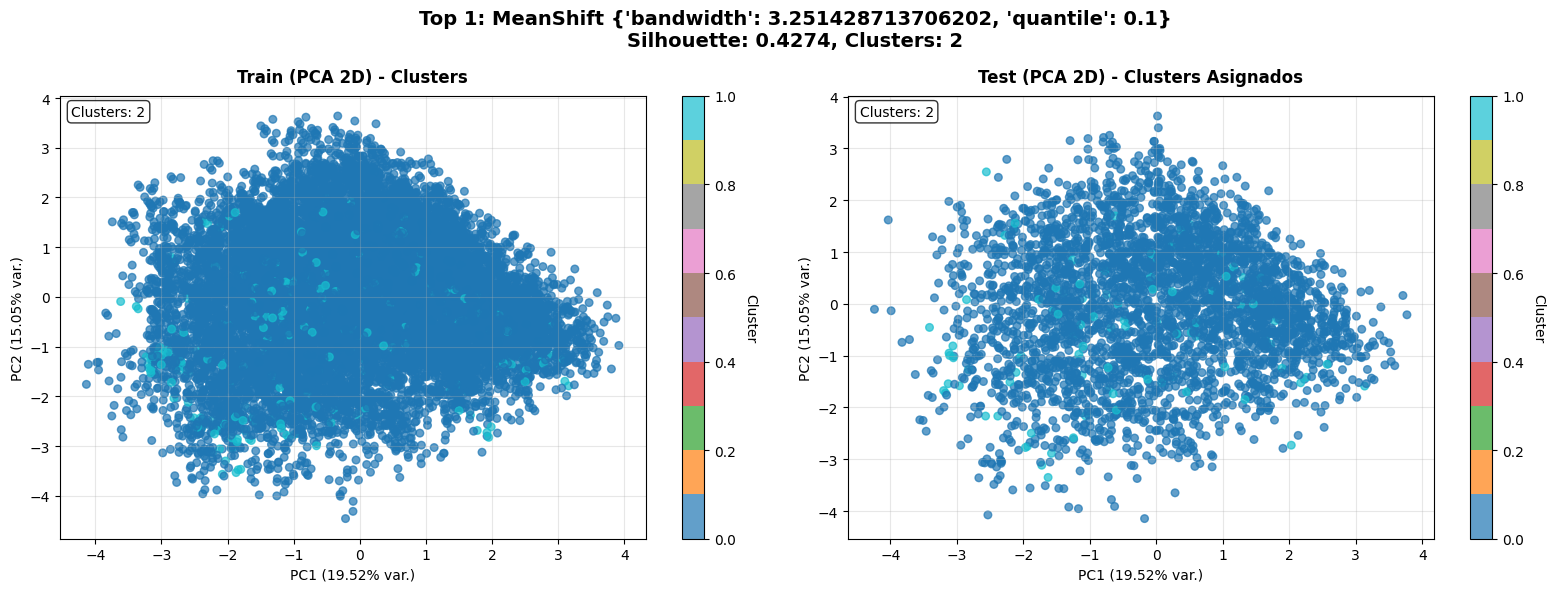

Varianza explicada por PC1: 0.1952 (19.52%)
Varianza explicada por PC2: 0.1505 (15.05%)
Varianza total explicada: 0.3457 (34.57%)

Top 2: MeanShift {'bandwidth': 3.692495307481828, 'quantile': 0.2} (sil=0.4274, n_clusters=2)


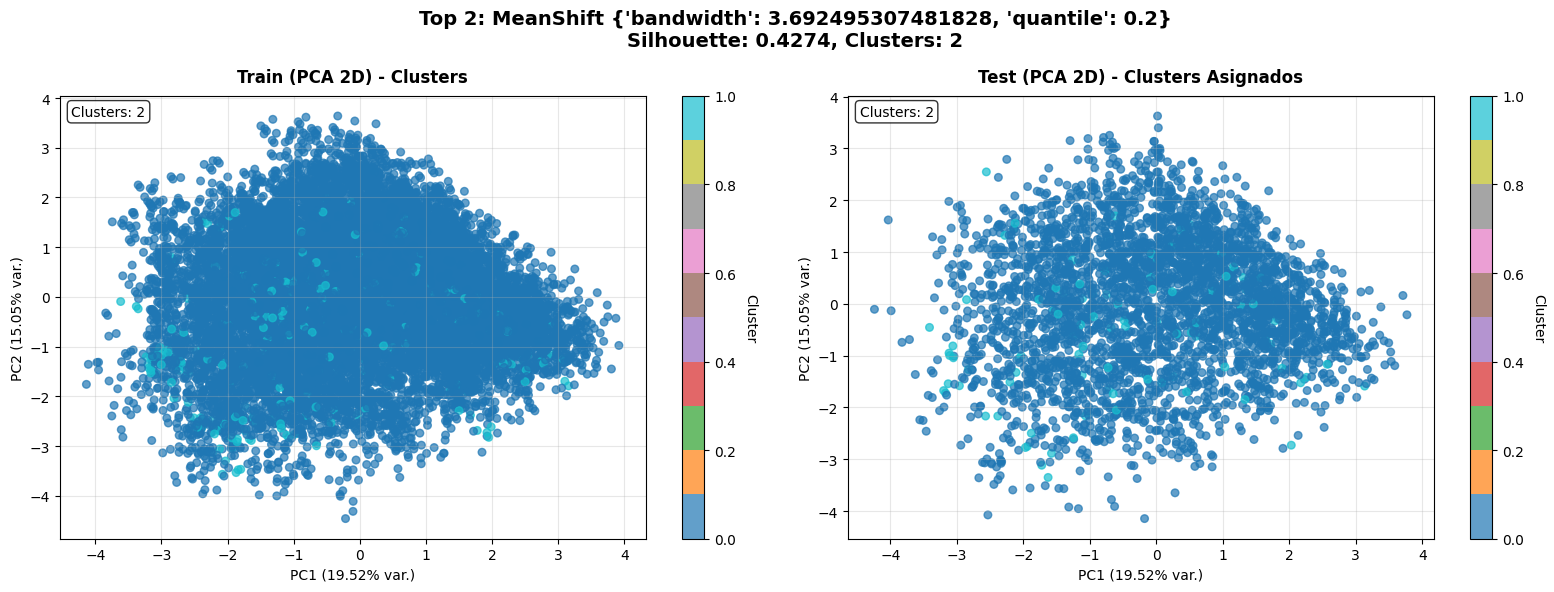

Varianza explicada por PC1: 0.1952 (19.52%)
Varianza explicada por PC2: 0.1505 (15.05%)
Varianza total explicada: 0.3457 (34.57%)

Top 3: MeanShift {'bandwidth': 4.00291972782932, 'quantile': 0.3} (sil=0.4274, n_clusters=2)


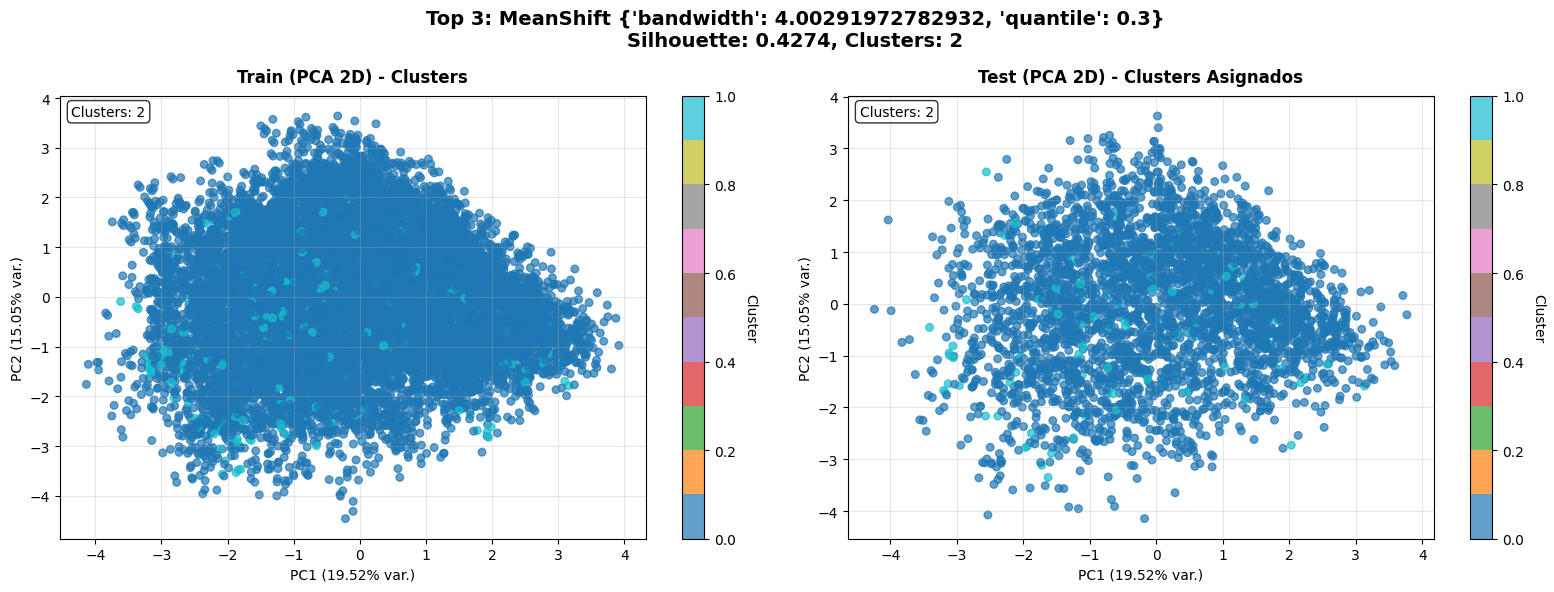

Varianza explicada por PC1: 0.1952 (19.52%)
Varianza explicada por PC2: 0.1505 (15.05%)
Varianza total explicada: 0.3457 (34.57%)

ANÁLISIS PCA 2D - EXPERIMENTO: SIN_CARACTERISTICAS_DE_TIEMPO

Top 1: MeanShift {'bandwidth': 2.881147336746371, 'quantile': 0.2} (sil=0.5027, n_clusters=2)


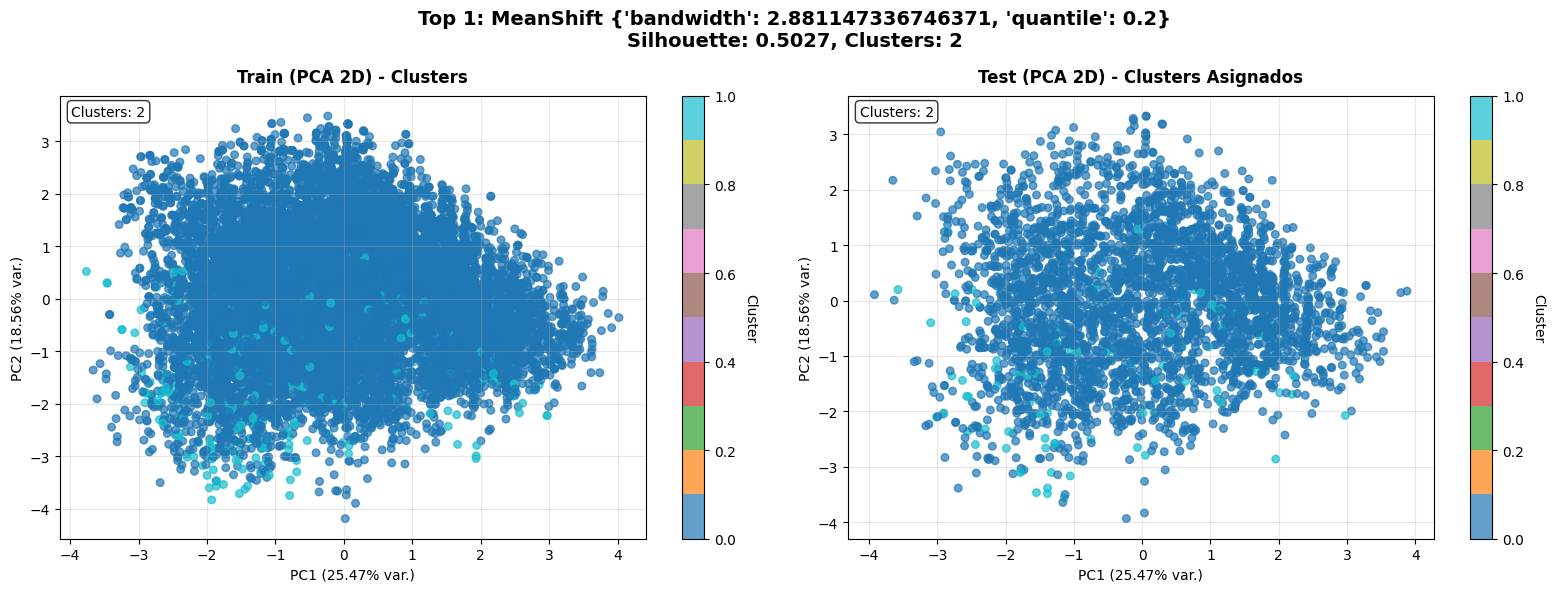

Varianza explicada por PC1: 0.2547 (25.47%)
Varianza explicada por PC2: 0.1856 (18.56%)
Varianza total explicada: 0.4403 (44.03%)

Top 2: MeanShift {'bandwidth': 3.202325325643995, 'quantile': 0.3} (sil=0.5027, n_clusters=2)


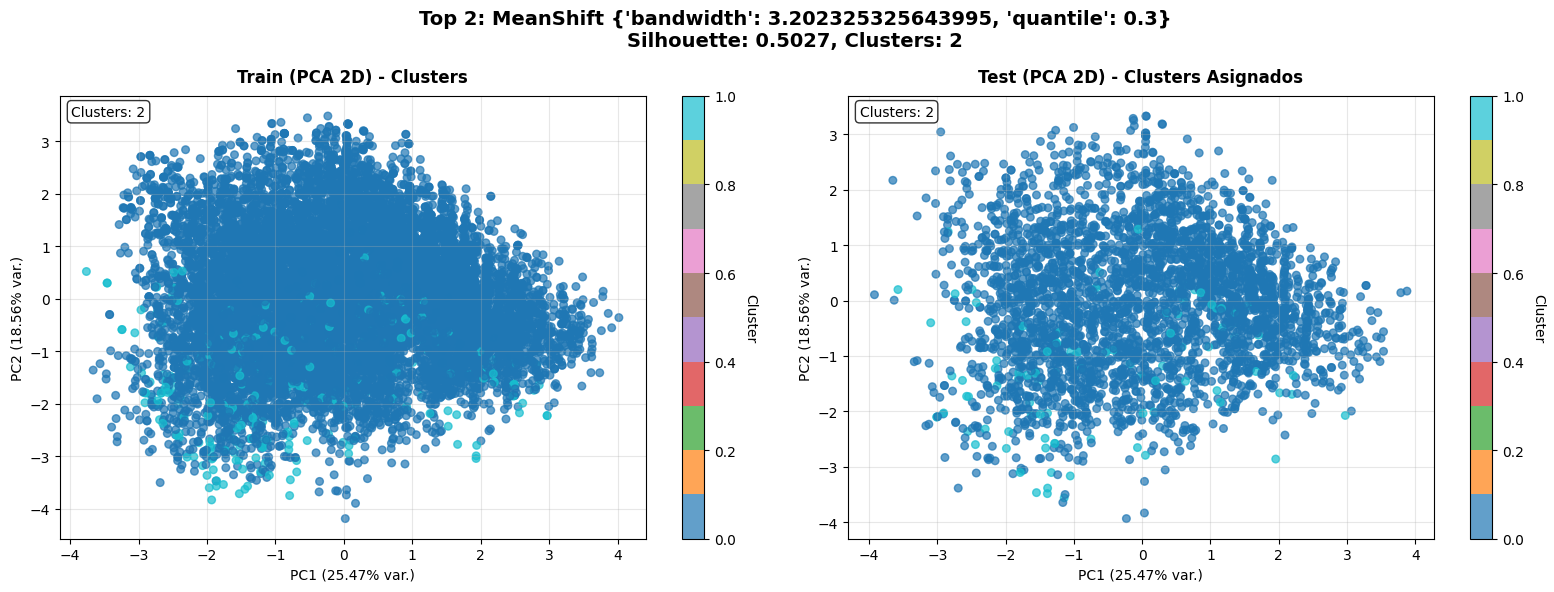

Varianza explicada por PC1: 0.2547 (25.47%)
Varianza explicada por PC2: 0.1856 (18.56%)
Varianza total explicada: 0.4403 (44.03%)

Top 3: MeanShift {'bandwidth': 3.7349975363823398, 'quantile': 0.5} (sil=0.5027, n_clusters=2)


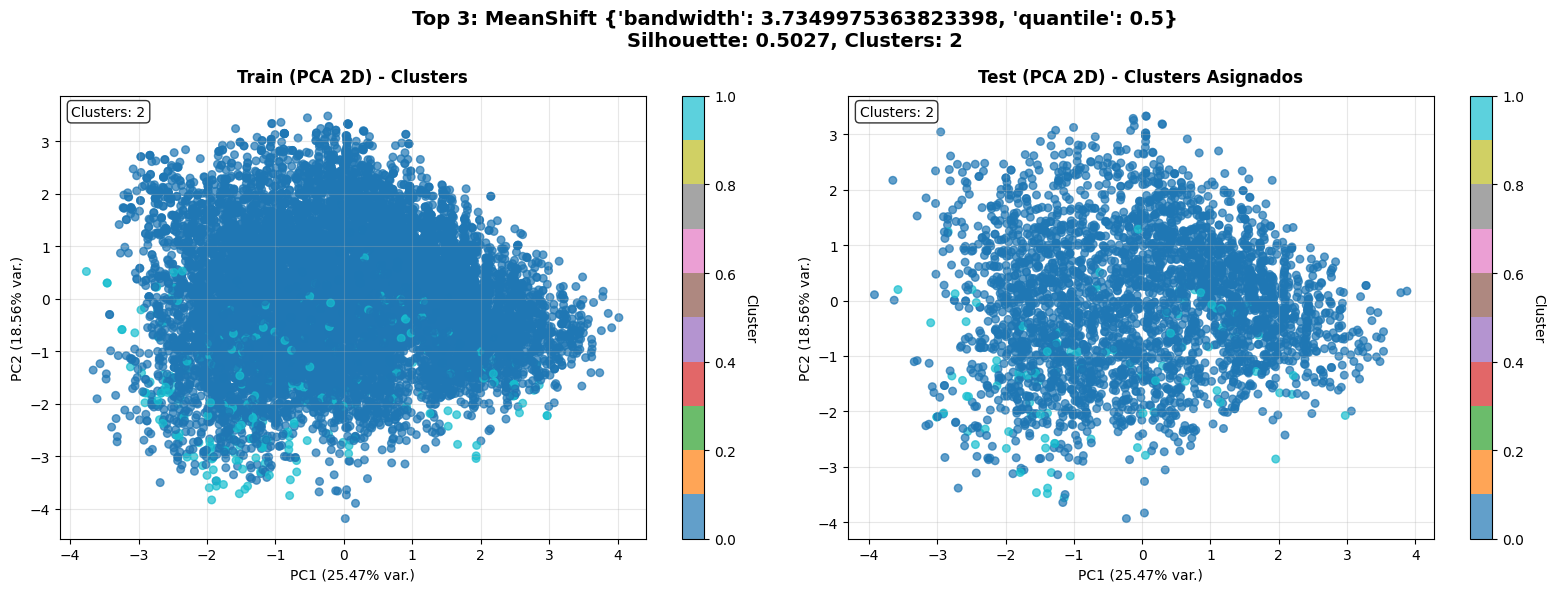

Varianza explicada por PC1: 0.2547 (25.47%)
Varianza explicada por PC2: 0.1856 (18.56%)
Varianza total explicada: 0.4403 (44.03%)

Generando comparación de métodos...


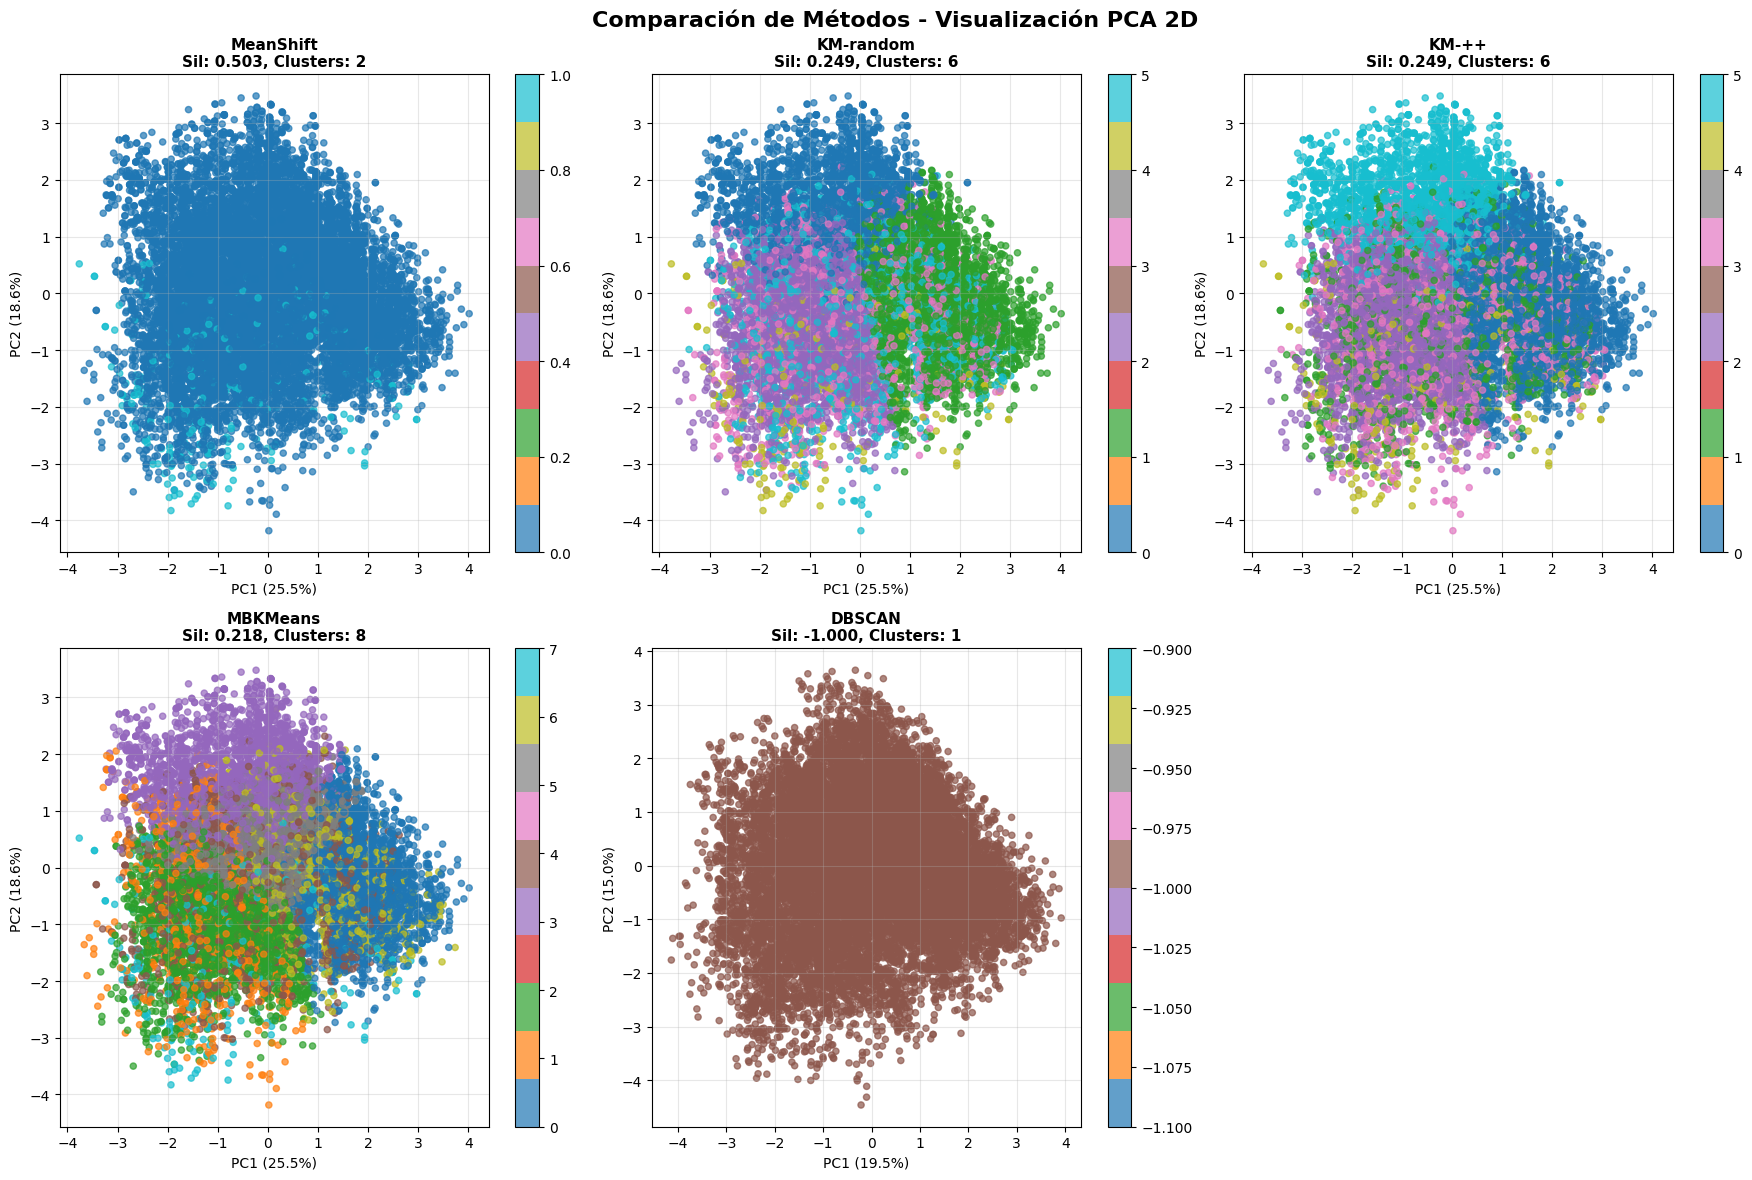


Generando análisis de densidad...


C:\Users\diego\AppData\Local\Temp\ipykernel_11092\4184186908.py:173: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = ax1.boxplot(cluster_sizes_data, labels=method_labels, patch_artist=True)


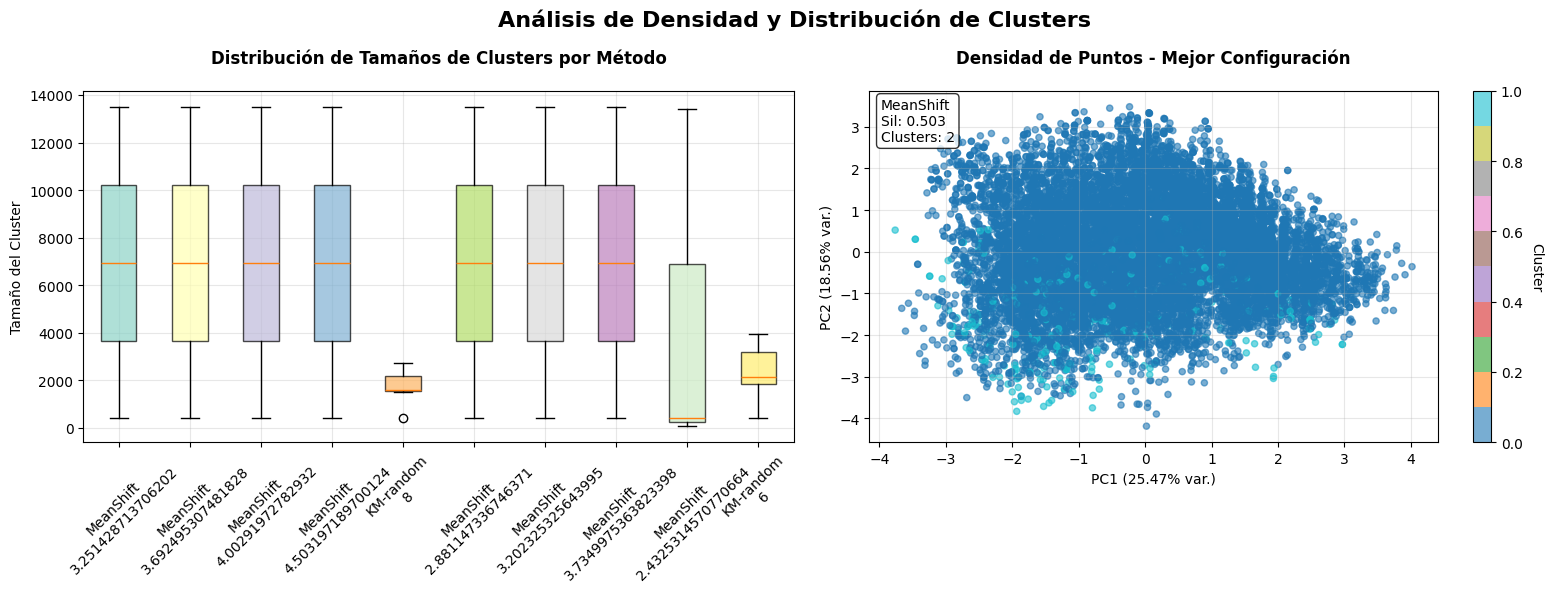

In [35]:
# 12) Gráficos de PCA 2D para visualización de clusters

def plot_pca_cluster_analysis(experiments, top_n=3):
    """Genera gráficos PCA 2D para las mejores configuraciones de cada experimento"""
    
    for exp_name, results in experiments.items():
        print(f"\n{'='*80}")
        print(f"ANÁLISIS PCA 2D - EXPERIMENTO: {exp_name.upper()}")
        print(f"{'='*80}")
        
        # Tomar las top_n configuraciones
        top_configs = results[:top_n]
        
        for i, config in enumerate(top_configs, 1):
            metodo = config['metodo']
            parametros = config['parametros']
            silhouette = config['silhouette']
            n_clusters = config['n_clusters']
            modelo = config['modelo']
            X_train = config['X_entrenamiento']
            X_test = config['X_prueba']
            labels_train = config['etiquetas_entrenamiento']
            
            print(f"\nTop {i}: {metodo} {parametros} (sil={silhouette:.4f}, n_clusters={n_clusters})")
            
            # Crear figura con subplots
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
            fig.suptitle(f'Top {i}: {metodo} {parametros}\nSilhouette: {silhouette:.4f}, Clusters: {n_clusters}', 
                        fontsize=14, fontweight='bold')
            
            # Aplicar PCA a los datos de entrenamiento
            pca = PCA(n_components=2)
            X_train_pca = pca.fit_transform(X_train)
            
            # Gráfico 1: Datos de entrenamiento con clusters
            scatter1 = ax1.scatter(X_train_pca[:, 0], X_train_pca[:, 1], 
                                  c=labels_train, cmap='tab10', alpha=0.7, s=30)
            ax1.set_title('Train (PCA 2D) - Clusters', fontweight='bold', pad=10)
            ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} var.)')
            ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} var.)')
            ax1.grid(True, alpha=0.3)
            
            # Añadir colorbar para clusters
            cbar1 = plt.colorbar(scatter1, ax=ax1)
            cbar1.set_label('Cluster', rotation=270, labelpad=15)
            
            # Gráfico 2: Datos de prueba con clusters asignados
            # Predecir clusters en test
            try:
                if hasattr(modelo, 'predict'):
                    pred_clusters_test = modelo.predict(X_test)
                else:
                    from sklearn.metrics import pairwise_distances_argmin_min
                    if hasattr(modelo, 'cluster_centers_'):
                        pred_clusters_test, _ = pairwise_distances_argmin_min(X_test, modelo.cluster_centers_)
                    else:
                        pred_clusters_test = np.array([-1] * len(X_test))
            except:
                pred_clusters_test = np.array([-1] * len(X_test))
            
            # Aplicar PCA a los datos de prueba (usando el mismo transformador de entrenamiento)
            X_test_pca = pca.transform(X_test)
            
            scatter2 = ax2.scatter(X_test_pca[:, 0], X_test_pca[:, 1], 
                                  c=pred_clusters_test, cmap='tab10', alpha=0.7, s=30)
            ax2.set_title('Test (PCA 2D) - Clusters Asignados', fontweight='bold', pad=10)
            ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} var.)')
            ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} var.)')
            ax2.grid(True, alpha=0.3)
            
            # Añadir colorbar para clusters de test
            cbar2 = plt.colorbar(scatter2, ax=ax2)
            cbar2.set_label('Cluster', rotation=270, labelpad=15)
            
            # Añadir información adicional
            ax1.text(0.02, 0.98, f'Clusters: {n_clusters}', transform=ax1.transAxes, 
                    fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            
            ax2.text(0.02, 0.98, f'Clusters: {len(set(pred_clusters_test))}', transform=ax2.transAxes, 
                    fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            
            plt.tight_layout()
            plt.show()
            
            # Información adicional sobre la varianza explicada
            print(f"Varianza explicada por PC1: {pca.explained_variance_ratio_[0]:.4f} ({pca.explained_variance_ratio_[0]:.2%})")
            print(f"Varianza explicada por PC2: {pca.explained_variance_ratio_[1]:.4f} ({pca.explained_variance_ratio_[1]:.2%})")
            print(f"Varianza total explicada: {sum(pca.explained_variance_ratio_):.4f} ({sum(pca.explained_variance_ratio_):.2%})")

# Función adicional para gráficos de comparación de métodos
def plot_cluster_comparison_pca(experiments):
    """Compara diferentes métodos en un solo gráfico PCA 2D"""
    
    # Tomar el mejor resultado de cada tipo de método
    best_methods = {}
    
    for exp_name, results in experiments.items():
        for result in results:
            metodo = result['metodo']
            if metodo not in best_methods or result['silhouette'] > best_methods[metodo]['silhouette']:
                best_methods[metodo] = result
    
    # Crear gráfico comparativo
    n_methods = len(best_methods)
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Comparación de Métodos - Visualización PCA 2D', fontsize=16, fontweight='bold')
    
    axes = axes.flatten()
    
    for idx, (metodo, result) in enumerate(best_methods.items()):
        if idx >= len(axes):
            break
            
        ax = axes[idx]
        X_train = result['X_entrenamiento']
        labels_train = result['etiquetas_entrenamiento']
        silhouette = result['silhouette']
        n_clusters = result['n_clusters']
        
        # Aplicar PCA
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X_train)
        
        scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], 
                           c=labels_train, cmap='tab10', alpha=0.7, s=20)
        
        # Título con información del método
        metodo_corto = metodo.replace('KMeans-', 'KM-').replace('MiniBatch', 'MB')
        ax.set_title(f'{metodo_corto}\nSil: {silhouette:.3f}, Clusters: {n_clusters}', 
                    fontweight='bold', fontsize=11)
        ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
        ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
        ax.grid(True, alpha=0.3)
        
        # Añadir colorbar
        plt.colorbar(scatter, ax=ax)
    
    # Ocultar ejes vacíos
    for idx in range(len(best_methods), len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()

# Función para análisis de densidad de clusters
def plot_cluster_density_analysis(experiments):
    """Análisis de densidad y distribución de clusters"""
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('Análisis de Densidad y Distribución de Clusters', fontsize=16, fontweight='bold')
    
    # Gráfico 1: Distribución de tamaños de clusters por método
    ax1.set_title('Distribución de Tamaños de Clusters por Método', fontweight='bold', pad=20)
    
    cluster_sizes_data = []
    method_labels = []
    
    for exp_name, results in experiments.items():
        for result in results[:5]:  # Tomar primeros 5 de cada experimento
            metodo = result['metodo']
            labels = result['etiquetas_entrenamiento']
            
            # Calcular tamaños de clusters
            unique, counts = np.unique(labels, return_counts=True)
            cluster_sizes_data.append(counts)
            
            # Etiqueta corta para el método
            metodo_corto = metodo.replace('KMeans-', 'KM-').replace('MiniBatch', 'MB')
            param_val = list(result['parametros'].values())[0]
            method_labels.append(f"{metodo_corto}\n{param_val}")
    
    # Boxplot de tamaños de clusters
    boxplot = ax1.boxplot(cluster_sizes_data, labels=method_labels, patch_artist=True)
    
    # Colorear las cajas
    colors = plt.cm.Set3(np.linspace(0, 1, len(cluster_sizes_data)))
    for patch, color in zip(boxplot['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax1.set_ylabel('Tamaño del Cluster')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(True, alpha=0.3)
    
    # Gráfico 2: Densidad de puntos por cluster (ejemplo con el mejor resultado)
    ax2.set_title('Densidad de Puntos - Mejor Configuración', fontweight='bold', pad=20)
    
    # Encontrar el mejor resultado global
    best_result = None
    for exp_name, results in experiments.items():
        for result in results:
            if best_result is None or result['silhouette'] > best_result['silhouette']:
                best_result = result
    
    if best_result:
        X_train = best_result['X_entrenamiento']
        labels = best_result['etiquetas_entrenamiento']
        
        # Aplicar PCA para visualización
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X_train)
        
        # Crear scatter plot con densidad
        scatter = ax2.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='tab10', alpha=0.6, s=20)
        ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} var.)')
        ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} var.)')
        ax2.grid(True, alpha=0.3)
        
        # Añadir colorbar
        cbar = plt.colorbar(scatter, ax=ax2)
        cbar.set_label('Cluster', rotation=270, labelpad=15)
        
        # Añadir información
        metodo = best_result['metodo']
        silhouette = best_result['silhouette']
        n_clusters = best_result['n_clusters']
        ax2.text(0.02, 0.98, f'{metodo}\nSil: {silhouette:.3f}\nClusters: {n_clusters}', 
                transform=ax2.transAxes, fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

# Ejecutar los gráficos de PCA
print("Generando gráficos de análisis PCA 2D...")
plot_pca_cluster_analysis(experiments, top_n=3)

print("\nGenerando comparación de métodos...")
plot_cluster_comparison_pca(experiments)

print("\nGenerando análisis de densidad...")
plot_cluster_density_analysis(experiments)

NOTA: Este bloque imprime todos los gráficos en un solo punto, por lo que si quieres visualizar de mejor forma los resultados, descomentar este bloque para visualizar los resultados anteriores.

Generando gráficos tradicionales mejorados...


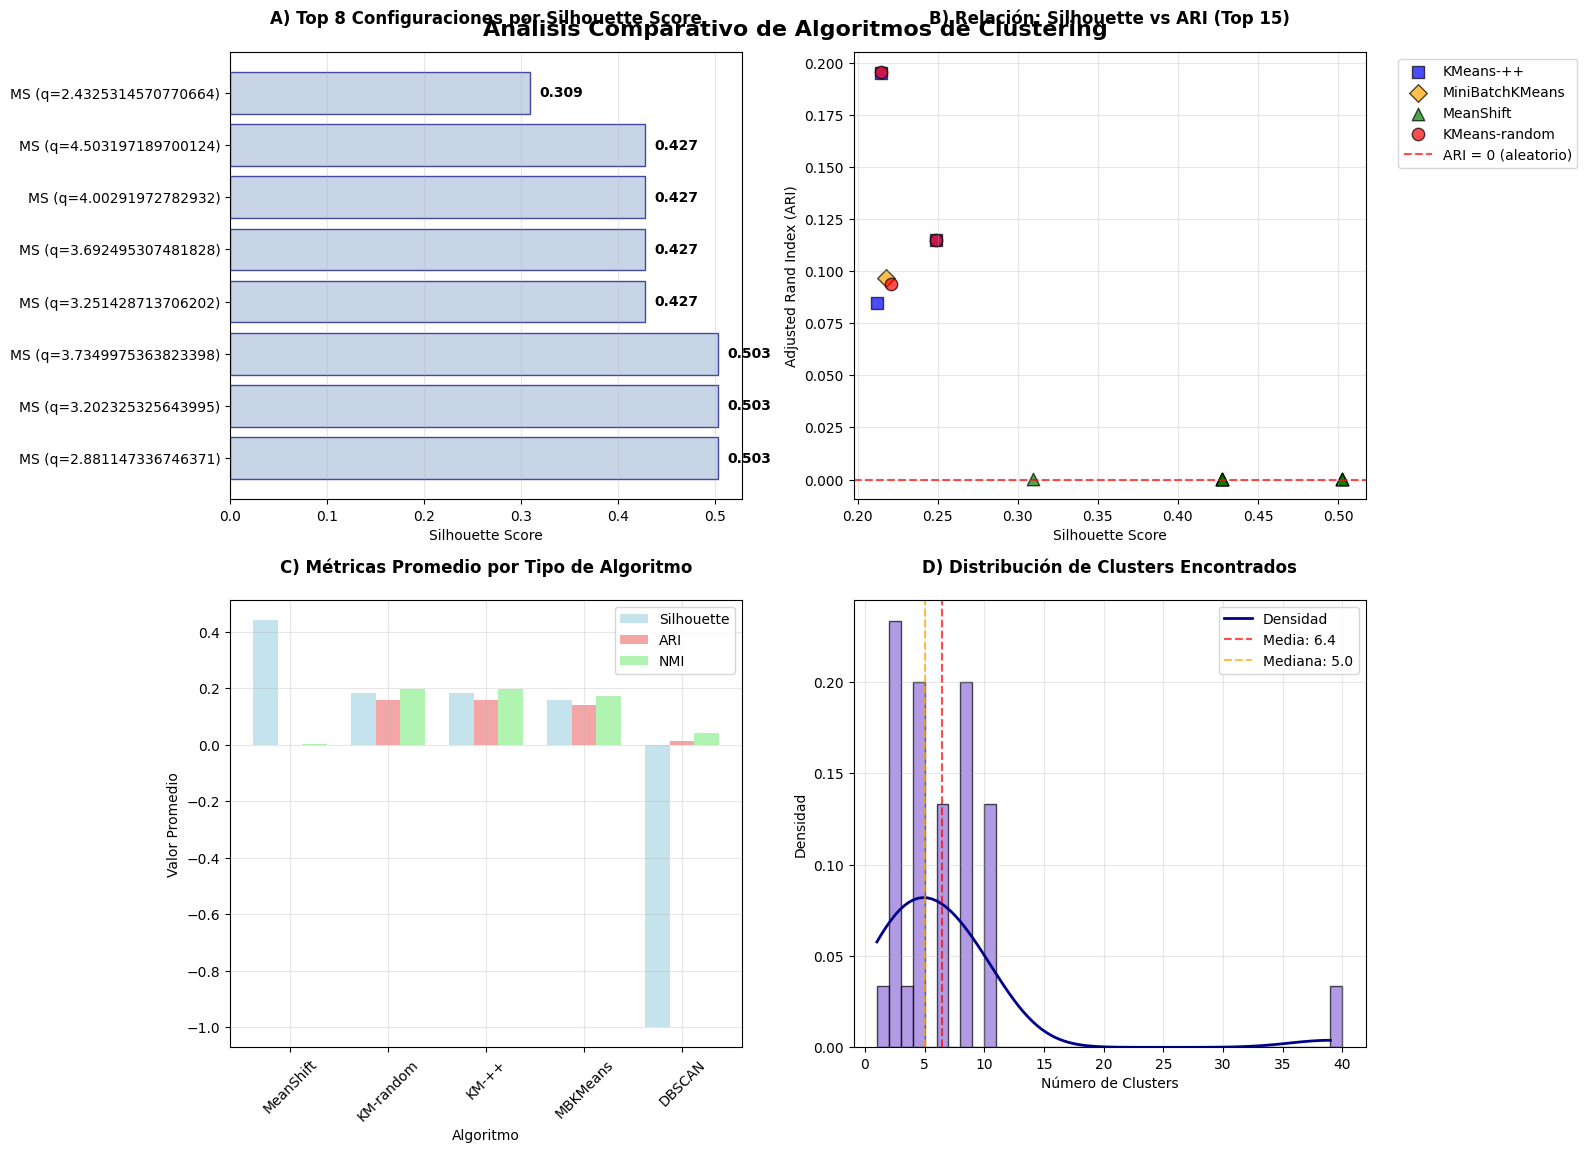

In [ ]:
# 13) Gráficos tradicionales para análisis de resultados

def plot_improved_traditional_analysis(experiments):
    """Gráficos tradicionales mejorados para evitar solapamiento"""
    
    plt.style.use('default')
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Análisis Comparativo de Algoritmos de Clustering', 
                 fontsize=16, fontweight='bold', y=0.95)
    
    # 1. TOP 8 Métodos por Silhouette (BARRAS HORIZONTALES para mejor legibilidad)
    ax1 = axes[0, 0]
    
    # Recolectar y ordenar métodos
    all_results = []
    for exp_name, results in experiments.items():
        for result in results:
            all_results.append(result)
    
    # Ordenar y tomar top 8
    top_8 = sorted(all_results, key=lambda x: x['silhouette'], reverse=True)[:8]
    
    methods = []
    silhouettes = []
    
    for result in top_8:
        metodo = result['metodo']
        param_val = list(result['parametros'].values())[0]
        
        # Nombres cortos y consistentes
        if metodo == 'KMeans-random':
            name = f"KM-Rnd (k={param_val})"
        elif metodo == 'KMeans-++':
            name = f"KM++ (k={param_val})"
        elif metodo == 'MeanShift':
            name = f"MS (q={param_val})"
        elif metodo == 'MiniBatchKMeans':
            name = f"MB-KM (k={param_val})"
        elif metodo == 'DBSCAN':
            name = "DBSCAN"
        else:
            name = f"{metodo} ({param_val})"
            
        methods.append(name)
        silhouettes.append(result['silhouette'])
    
    # Gráfico de barras HORIZONTAL
    y_pos = np.arange(len(methods))
    bars = ax1.barh(y_pos, silhouettes, color='lightsteelblue', alpha=0.7, edgecolor='navy')
    
    ax1.set_title('A) Top 8 Configuraciones por Silhouette Score', fontweight='bold', pad=20)
    ax1.set_xlabel('Silhouette Score')
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(methods)
    ax1.grid(True, alpha=0.3, axis='x')
    
    # Añadir valores en las barras
    for bar, val in zip(bars, silhouettes):
        width = bar.get_width()
        ax1.text(width + 0.01, bar.get_y() + bar.get_height()/2, 
                f'{val:.3f}', ha='left', va='center', fontsize=10, fontweight='bold')
    
    # 2. Comparación ARI vs Silhouette (TOP 15 para claridad)
    ax2 = axes[0, 1]
    
    top_15 = sorted(all_results, key=lambda x: x['silhouette'], reverse=True)[:15]
    sil_top = [r['silhouette'] for r in top_15]
    ari_top = [r['ari'] for r in top_15]
    methods_top = [r['metodo'] for r in top_15]
    
    # Colores y marcadores diferentes por método
    color_map = {
        'KMeans-random': ('red', 'o'),
        'KMeans-++': ('blue', 's'), 
        'MeanShift': ('green', '^'),
        'MiniBatchKMeans': ('orange', 'D'),
        'DBSCAN': ('purple', 'v')
    }
    
    for metodo in set(methods_top):
        color, marker = color_map.get(metodo, ('gray', 'o'))
        mask = [m == metodo for m in methods_top]
        ax2.scatter(np.array(sil_top)[mask], np.array(ari_top)[mask], 
                   c=color, marker=marker, s=80, alpha=0.7, label=metodo, edgecolors='black')
    
    ax2.set_title('B) Relación: Silhouette vs ARI (Top 15)', fontweight='bold', pad=20)
    ax2.set_xlabel('Silhouette Score')
    ax2.set_ylabel('Adjusted Rand Index (ARI)')
    ax2.axhline(y=0, color='red', linestyle='--', alpha=0.7, label='ARI = 0 (aleatorio)')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.grid(True, alpha=0.3)
    
    # 3. Métricas por Tipo de Algoritmo (promedios)
    ax3 = axes[1, 0]
    
    algorithm_data = {}
    for result in all_results:
        algo = result['metodo']
        if algo not in algorithm_data:
            algorithm_data[algo] = {'silhouette': [], 'ari': [], 'nmi': []}
        algorithm_data[algo]['silhouette'].append(result['silhouette'])
        algorithm_data[algo]['ari'].append(result['ari'])
        algorithm_data[algo]['nmi'].append(result['nmi'])
    
    algorithms = list(algorithm_data.keys())
    # Nombres cortos para algoritmos
    algo_short = [algo.replace('KMeans-', 'KM-').replace('MiniBatch', 'MB') for algo in algorithms]
    
    avg_sil = [np.mean(algorithm_data[algo]['silhouette']) for algo in algorithms]
    avg_ari = [np.mean(algorithm_data[algo]['ari']) for algo in algorithms]
    avg_nmi = [np.mean(algorithm_data[algo]['nmi']) for algo in algorithms]
    
    x = np.arange(len(algorithms))
    width = 0.25
    
    bars1 = ax3.bar(x - width, avg_sil, width, label='Silhouette', alpha=0.7, color='lightblue')
    bars2 = ax3.bar(x, avg_ari, width, label='ARI', alpha=0.7, color='lightcoral')
    bars3 = ax3.bar(x + width, avg_nmi, width, label='NMI', alpha=0.7, color='lightgreen')
    
    ax3.set_title('C) Métricas Promedio por Tipo de Algoritmo', fontweight='bold', pad=20)
    ax3.set_xlabel('Algoritmo')
    ax3.set_ylabel('Valor Promedio')
    ax3.set_xticks(x)
    ax3.set_xticklabels(algo_short, rotation=45)
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Distribución de Número de Clusters Encontrados
    ax4 = axes[1, 1]
    
    cluster_counts = [r['n_clusters'] for r in all_results]
    
    # Histograma con KDE
    n, bins, patches = ax4.hist(cluster_counts, bins=range(min(cluster_counts), max(cluster_counts)+2), 
                               alpha=0.7, color='mediumpurple', edgecolor='black', density=True)
    
    # Añadir línea de densidad
    from scipy.stats import gaussian_kde
    kde = gaussian_kde(cluster_counts)
    x_range = np.linspace(min(cluster_counts), max(cluster_counts), 100)
    ax4.plot(x_range, kde(x_range), color='darkblue', linewidth=2, label='Densidad')
    
    ax4.set_title('D) Distribución de Clusters Encontrados', fontweight='bold', pad=20)
    ax4.set_xlabel('Número de Clusters')
    ax4.set_ylabel('Densidad')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # Añadir estadísticas
    mean_clusters = np.mean(cluster_counts)
    median_clusters = np.median(cluster_counts)
    ax4.axvline(mean_clusters, color='red', linestyle='--', alpha=0.7, label=f'Media: {mean_clusters:.1f}')
    ax4.axvline(median_clusters, color='orange', linestyle='--', alpha=0.7, label=f'Mediana: {median_clusters:.1f}')
    ax4.legend()
    
    plt.tight_layout()
    plt.show()

# Ejecucion de gráficos 
print("Generando gráficos  tradicionales...")
plot_improved_traditional_analysis(experiments)


## 13) Observaciones y conclusiones

1. El dataset `hour.csv` tiene ~17,000 filas, cumpliendo el requisito de ≥10,000 filas.
2. **Resultado central:** A pesar de que **MeanShift** obtuvo los mayores valores de Silhouette en varios casos (particiones geométricamente coherentes, sil≈0.4–0.5), las métricas que comparan clustering con la etiqueta `season` (ARI y NMI) son **prácticamente cero**, y la **accuracy** al asignar la etiqueta dominante por cluster ronda el baseline aleatorio (~0.25). Por tanto, **los clusters no representan la variable `season`**.

3. **Efecto de features temporales:** Incluir `mnth` y `hr` facilita la recuperación de `season` (por correlación directa). Por eso se incluyó el experimento **without_time_features**. La comparación muestra que, aun quitando esos proxies, los clusters siguen sin alinearse con `season`.

4. **Recomendación práctica:** Si el objetivo es **predecir `season`**, usar clustering no supervisado para asignar etiquetas **no** es una buena estrategia en este dataset. Recomendamos entrenar modelos supervisados (RandomForest/XGBoost) que aprovechen las señales para clasificación. Clustering puede ser útil para análisis exploratorio o para detectar subgrupos de demanda que no coinciden con estaciones.